In [1]:
import matplotlib.pyplot as plt
# Imports to enable scaled vector graphics
# %matplotlib notebook
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Physics data is modeled in **SDOFOscillator**. It will be the source of ground truth data.

In [2]:
from pvibrations import SDOFOscillator

In [3]:
tstep = 0.0001 # Adjust this variable to improve Euler's Method
# physics = SDOFOscillator(m=5, c=50, k=30000, h=tstep, time_duration=0.3)
physics = SDOFOscillator(m=5, c=50, k=20000, h=tstep, time_duration=1)
physics.compute_analytical()
physics.compute_euler()

A **Functional approach** using Tensorflow will be adopted to develop the physics informed machine learning model. Subclassing has avoided due to challanges writting the custom training loop. 

In [4]:
import tensorflow as tf
import numpy as np

In [5]:
class CustomLoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()

    def call(self, ytrue, ypred):
        diff = tf.square(ytrue - ypred)
        return tf.reduce_mean(diff)


In [6]:

class PhysicsOscillatorModel:
    def __init__(self, vib_physics, epochs=10000, l_rate=1e-4):
        self.vib_physics = vib_physics
        self.x_data = None
        self.t_data = None
        self.x_pred = None
        self.epochs = epochs
        self.l_rate = l_rate
        self.model = None
        self.t_physics = None
        self.collocation_points = 30
        self.vib_physics = vib_physics
        self.model_name = "vib_phy_model"
        # self.loss_fun = CustomLoss()
        self.loss_fun = tf.keras.losses.MeanSquaredError()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.l_rate)

    def prepare_data(self):

        t = self.vib_physics.get_time_true()
        x = self.vib_physics.get_x_true()

        # slice some data for training about 30 %
        sample_train_len = int(len(t) * 40 /100);
        sample_step = int(sample_train_len * 5 / 100)

        print(f"sample_train_len : {sample_train_len}")
        print(f"sample_step : {sample_step}")

        self.t_data = np.array(t[0:sample_train_len:sample_step])
        self.x_data = np.array(x[0:sample_train_len:sample_step])

        # Prepare the physics collocation points
        self.t_physics = np.linspace(0, t[len(t)-1], self.collocation_points)
        self.t_physics = self.t_physics.reshape((len(self.t_physics),1))
        self.t_physics = tf.Variable(self.t_physics, dtype="float32")

        # Reshape the numpy array because Tensorflow
        # will work with tensors with ndim >= 2
        t_data = self.t_data.reshape((len(self.t_data), 1))
        x_data = self.x_data.reshape((len(self.x_data), 1))

        return t_data, x_data

    def create_model(self, train=True):
        
        if train:
            # Training data 
            # Suggestion is to do normalization
            t_data, x_data = self.prepare_data()

            inputs = tf.keras.Input(shape=(1,))
            z = tf.keras.layers.Dense(32, activation="tanh")(inputs)
            z = tf.keras.layers.Dense(32, activation="tanh")(z)
            z = tf.keras.layers.Dense(32, activation="tanh")(z)
            outputs = tf.keras.layers.Dense(1,) (z)
            self.model = tf.keras.Model(inputs, outputs)
            self.model.compile()

            print(self.model.summary())

            # Custom training loop for the model
            for epoch in range(self.epochs):
                loss = self.train_step(t_data, x_data)

                if epoch % 1000 == 0:
                    print(f"End of epoch {epoch} : loss {loss}")

            self.save_model()
        else:
            self.load_model()


    def train_step(self, inputs, targets):
        t = inputs
        x = targets

        with tf.GradientTape() as tape, tf.GradientTape() as tape2, tf.GradientTape() as tape3, tf.GradientTape() as tape4:
            x_pred = self.model(t, training=True)

            # Compute the loss using a custom defined loss function
            loss = self.loss_fun(x, x_pred)


            # The initial conditions
            x0 = 0.08
            v0 = 0.0

            # boundary loss
            x0 = np.array([x0],dtype='float32').reshape((1,1))
            t0 = np.array([0],dtype='float32').reshape((1,1))
            t0 = tf.Variable(t0, dtype='float32')
            x0_pred = self.model(t0)
            x0_loss = self.l_rate * ((x0_pred - x0) ** 2)

            v0 = np.array([v0],dtype='float32').reshape((1,1))
            dtb = tape4.gradient(x0_pred, t0)
            v0_loss = self.l_rate * ((dtb - v0) **2)

            # Compute the loss based on vibration physics
            x_physics = self.model(self.t_physics)
            dt1 = tape2.gradient(x_physics, self.t_physics)
            dt2 = tape3.gradient(dt1, self.t_physics)

            c = self.vib_physics.c
            m = self.vib_physics.m
            k = self.vib_physics.k

            coefficients = [c, m, k]

            # Suggestion: make the denometer (den) the largest coefficient
            # Possibly improve physics loss and improve convergence
            # den = max(coefficients)
            den = m
            
            physics_constraint = (m*dt2) + (c * dt1 ) + (k * x_physics)

            physics_loss = self.l_rate * tf.reduce_mean(tf.square(physics_constraint))

            t_loss = loss + physics_loss
            # t_loss = loss 

            gradients = tape.gradient(t_loss, self.model.trainable_weights)

            # Update the weights. This is the learning in Machine Learning
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))
            
            return loss
            
    def save_model(self):
        self.model.save(self.model_name)

    def load_model(self):
        self.model = tf.keras.models.load_model(physics_model.model_name)
        self.model.compile()

    def test_model(self):
        t = np.array(self.vib_physics.get_time_true())
        t = t.reshape((len(t),1))
        
        self.x_pred = self.model.predict(t)
        self.t_physics = np.linspace(0, t[len(t)-1], self.collocation_points)

        # print(self.x_pred)

        plt.figure(figsize=(12,5))
        plt.title("Data Based Machine Learning")
        plt.plot(physics.get_t(), physics.get_x(), label="Euler")
        plt.plot(t, self.x_pred, label="Model")
        plt.scatter(self.t_data, self.x_data, label="Samples")
        plt.scatter(self.t_physics.reshape((self.collocation_points,)), np.zeros(self.t_physics.shape[0]), label="Collocation")
        plt.xlabel("time (t)")
        plt.ylabel("x")
        plt.ylim(-0.09, 0.09)
        plt.legend()
        plt.legend()


In [7]:
physics_model = PhysicsOscillatorModel(vib_physics=physics,epochs=40000)
physics_model.create_model(train=True)

sample_train_len : 4000
sample_step : 200
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 32)                64        
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,209
Trainable params: 2,209
Non-trainable params: 0
_________________________________________________________________
None
End of epoch

313/313 [==============================] - 0s 1ms/step


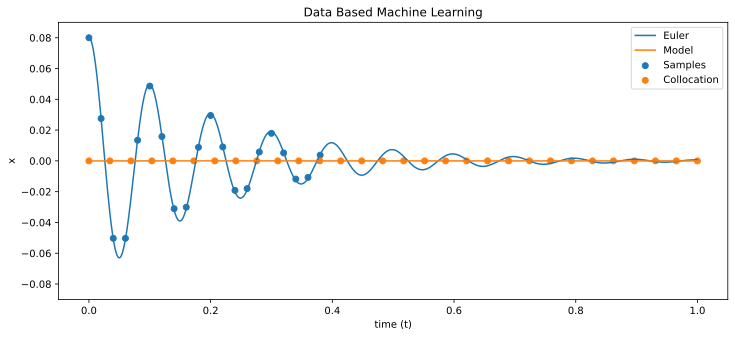

In [8]:
physics_model.test_model()